In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from metrics import calculate_rmse, calculate_psnr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def factorize(A, k, device=torch.device("cpu"), epochs=1000):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer use gradient decent (normal, not stochastic)
    optimizer = optim.SGD([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(epochs):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

torch.Size([3, 1365, 2048])
torch.Size([1365, 2048])


C:\Users\karan\AppData\Local\Temp\ipykernel_19584\4269189636.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


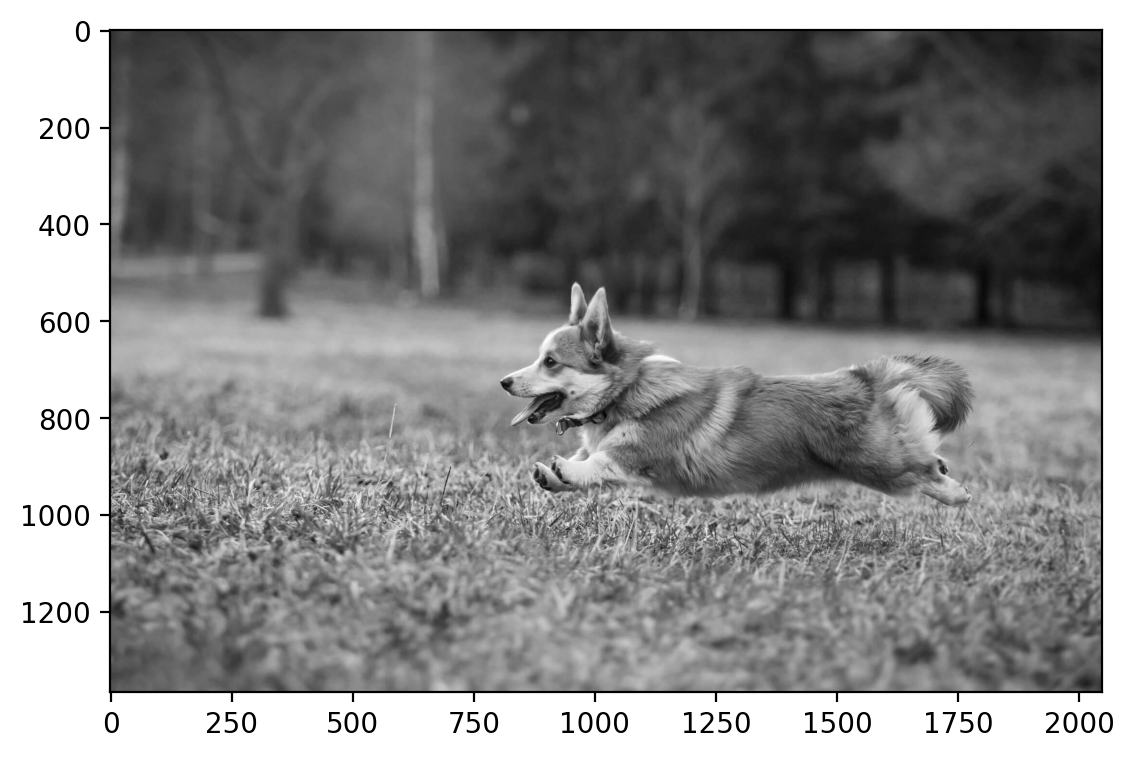

In [16]:
# Read in a image from torchvision
img = torchvision.io.read_image("./sample_images/SAM dog.jpg")
print(img.shape)
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)
plt.imshow(img, cmap='gray')

torch.Size([300, 300])


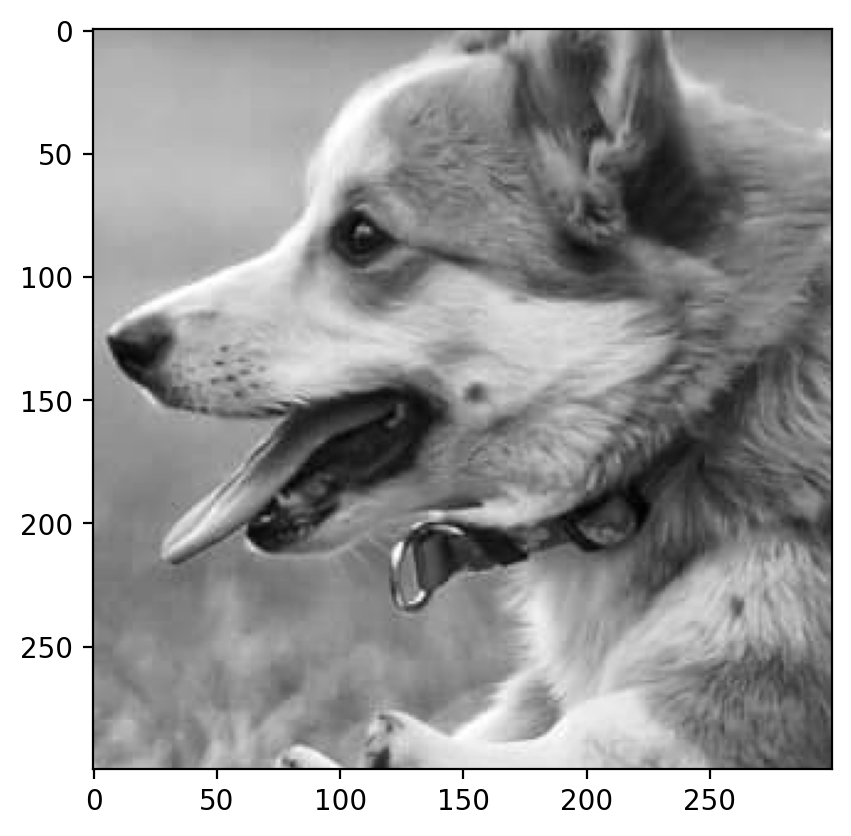

In [17]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
# crop = img
print(crop.shape)
plt.imshow(crop, cmap='gray')

In [18]:
def get_patch(img, case):
    match case:
        case 1:
            return img[:50, :50]
        case 2:
            return img[50:100, 50:100]
        case 3:
            return img[175:225, 75:125]

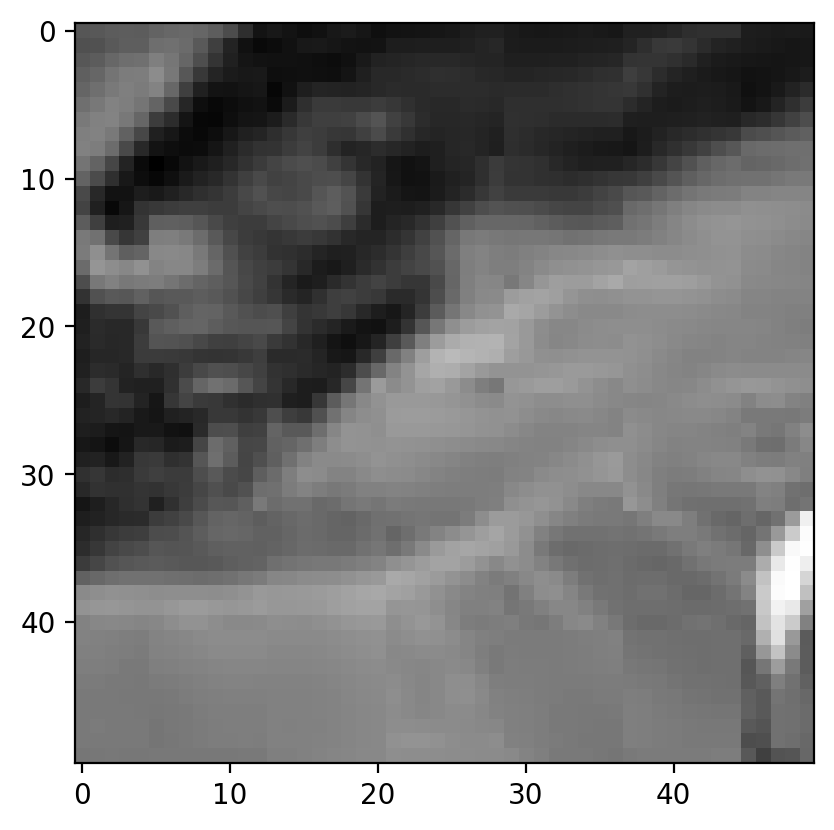

In [19]:
patch = get_patch(crop, 3)
plt.imshow(patch, cmap='gray')


In [20]:
W, H, _ = factorize(patch, 10, device=device, epochs=5000)

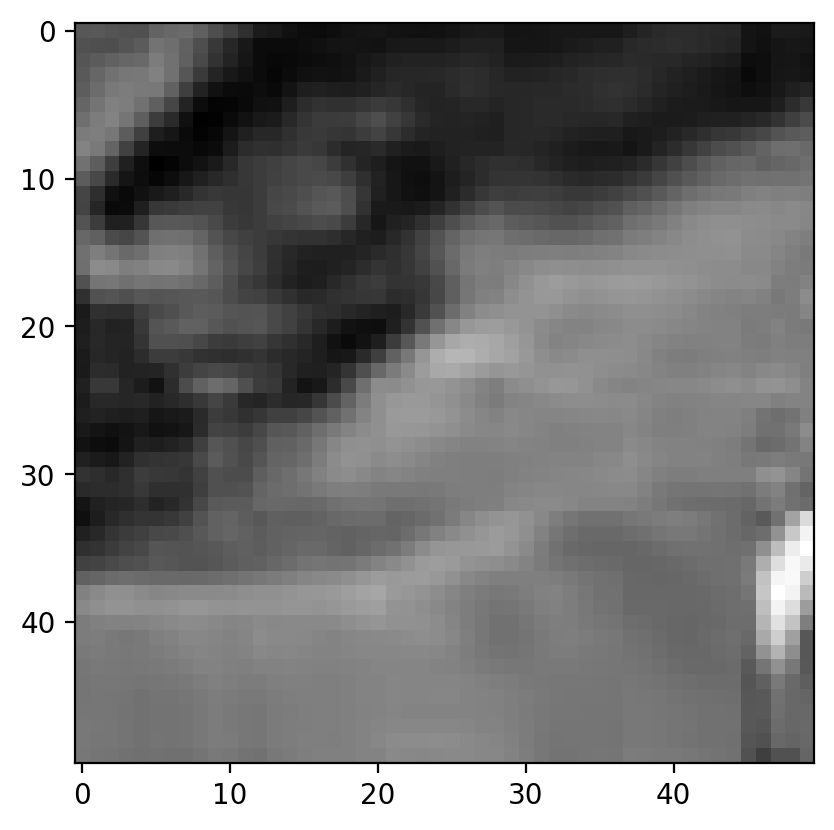

In [21]:
plt.imshow(torch.mm(W, H).detach().cpu(), cmap='gray')

In [22]:
def plot_original_reconstructed(original, reconstructed):
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].imshow(original, cmap='gray')
	ax[0].set_title("Original")
	ax[1].imshow(reconstructed, cmap='gray')
	ax[1].set_title("Reconstructed")
	plt.show()
 
def calculate_metrics(original, reconstructed):
	rmse = calculate_rmse(original, reconstructed)
	psnr = calculate_psnr(original, reconstructed)
	return rmse, psnr
 
def factorize_and_reconstruct_patch(patch, r, plot=False):
	patch = get_patch(crop, patch)
	W, H, _ = factorize(patch, r, device=device, epochs=1000)
	reconstructed = torch.mm(W, H).detach().cpu()
	if plot:
		plot_original_reconstructed(patch, reconstructed)
	return calculate_metrics(patch.detach().numpy(), reconstructed.detach().numpy())
 
def plot_metrics_vs_r(patch, r_values):
	rmse_values = []
	psnr_values = []
	for r in r_values:
		rmse, psnr = factorize_and_reconstruct_patch(patch, r, plot=False)
		rmse_values.append(rmse)
		psnr_values.append(psnr)
		print(f"patch={patch} r={r}, RMSE={rmse}, PSNR={psnr}")
 
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].plot(r_values, rmse_values)
	ax[0].set_title("RMSE vs r for patch {}".format(patch))
	ax[0].set_xlabel("r")
	ax[0].set_ylabel("RMSE")
	ax[1].plot(r_values, psnr_values)
	ax[1].set_title("PSNR vs r for patch {}".format(patch))
	ax[1].set_xlabel("r")
	ax[1].set_ylabel("PSNR")
	plt.show()


Patch 1


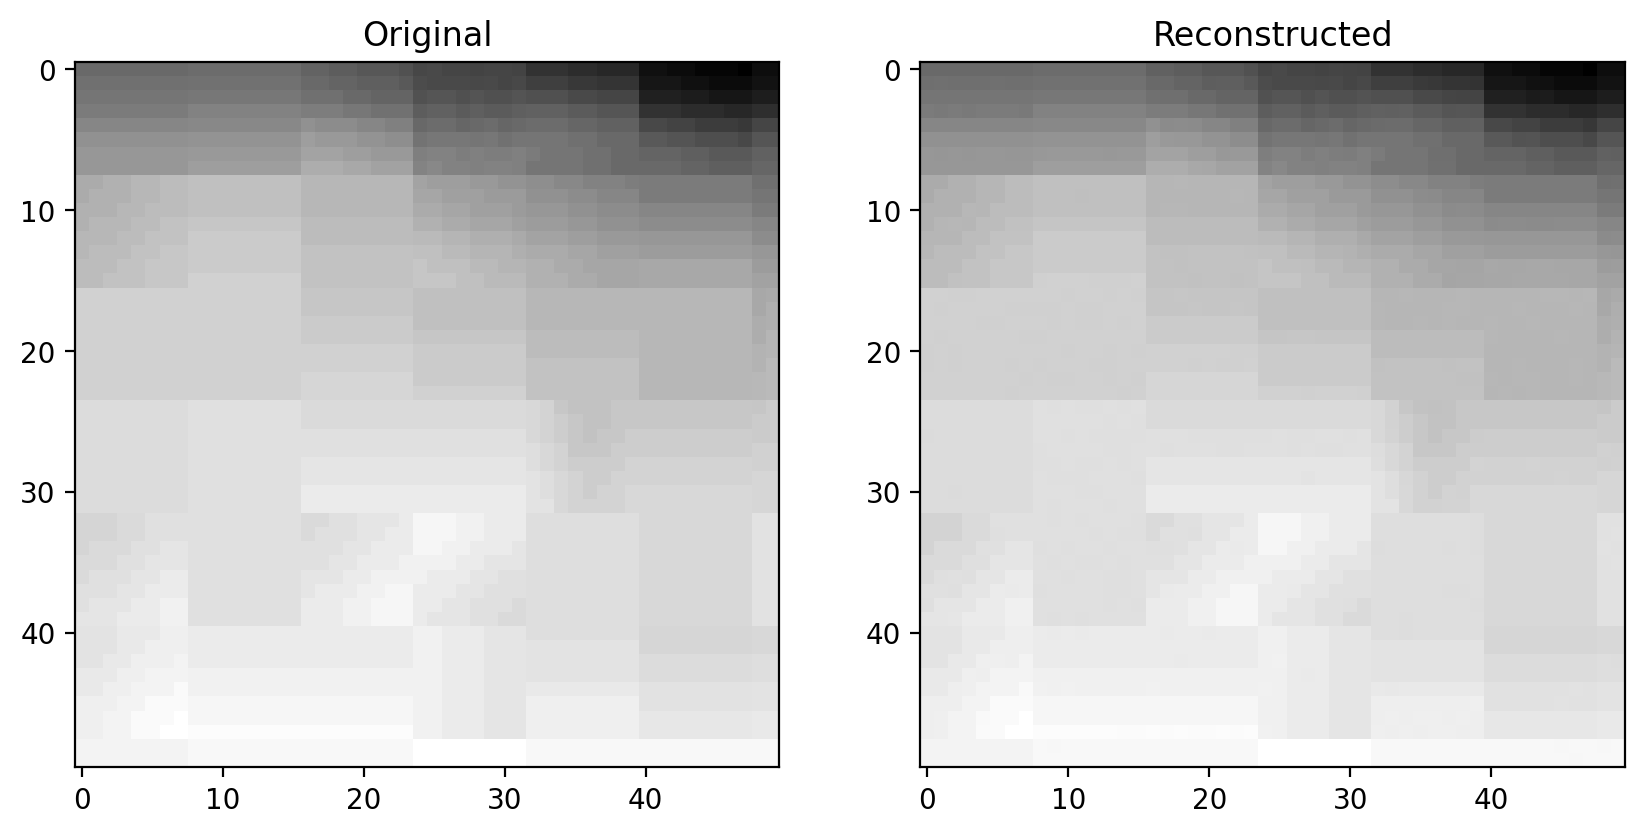

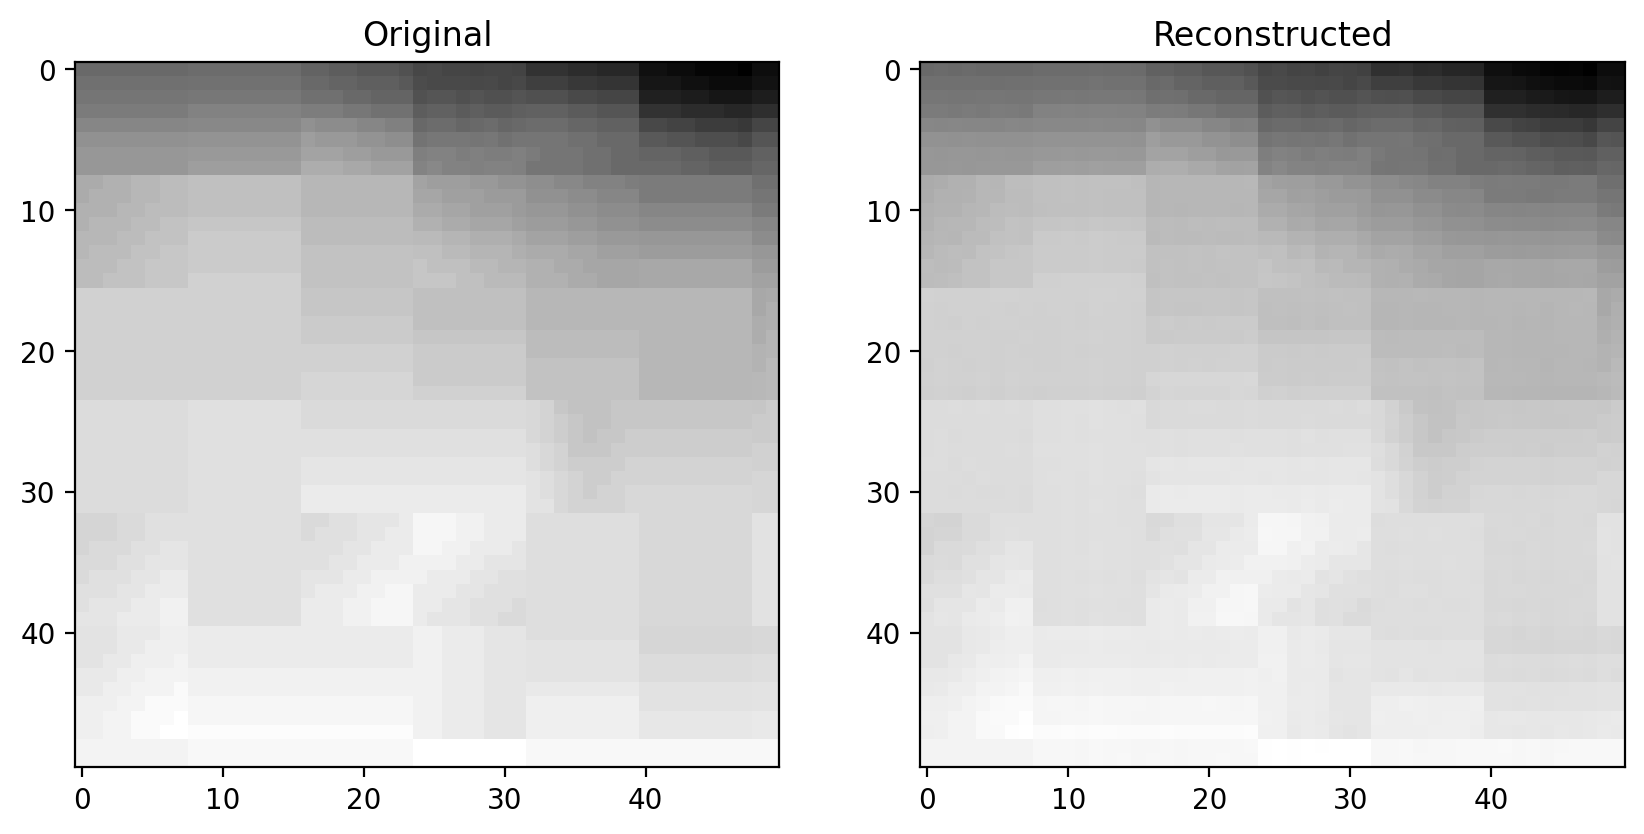

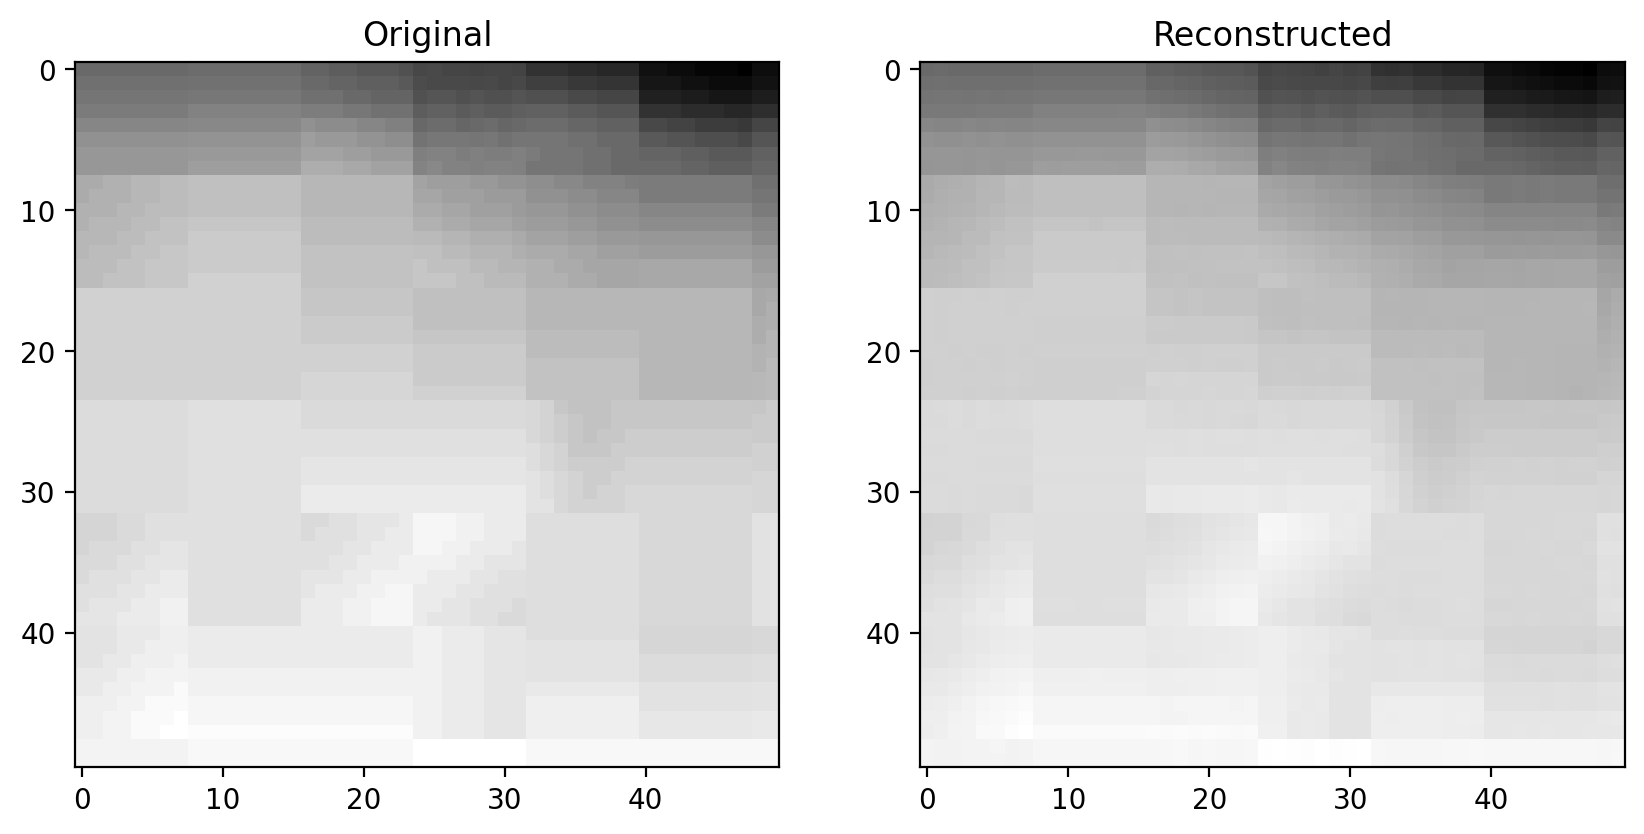

Patch 2


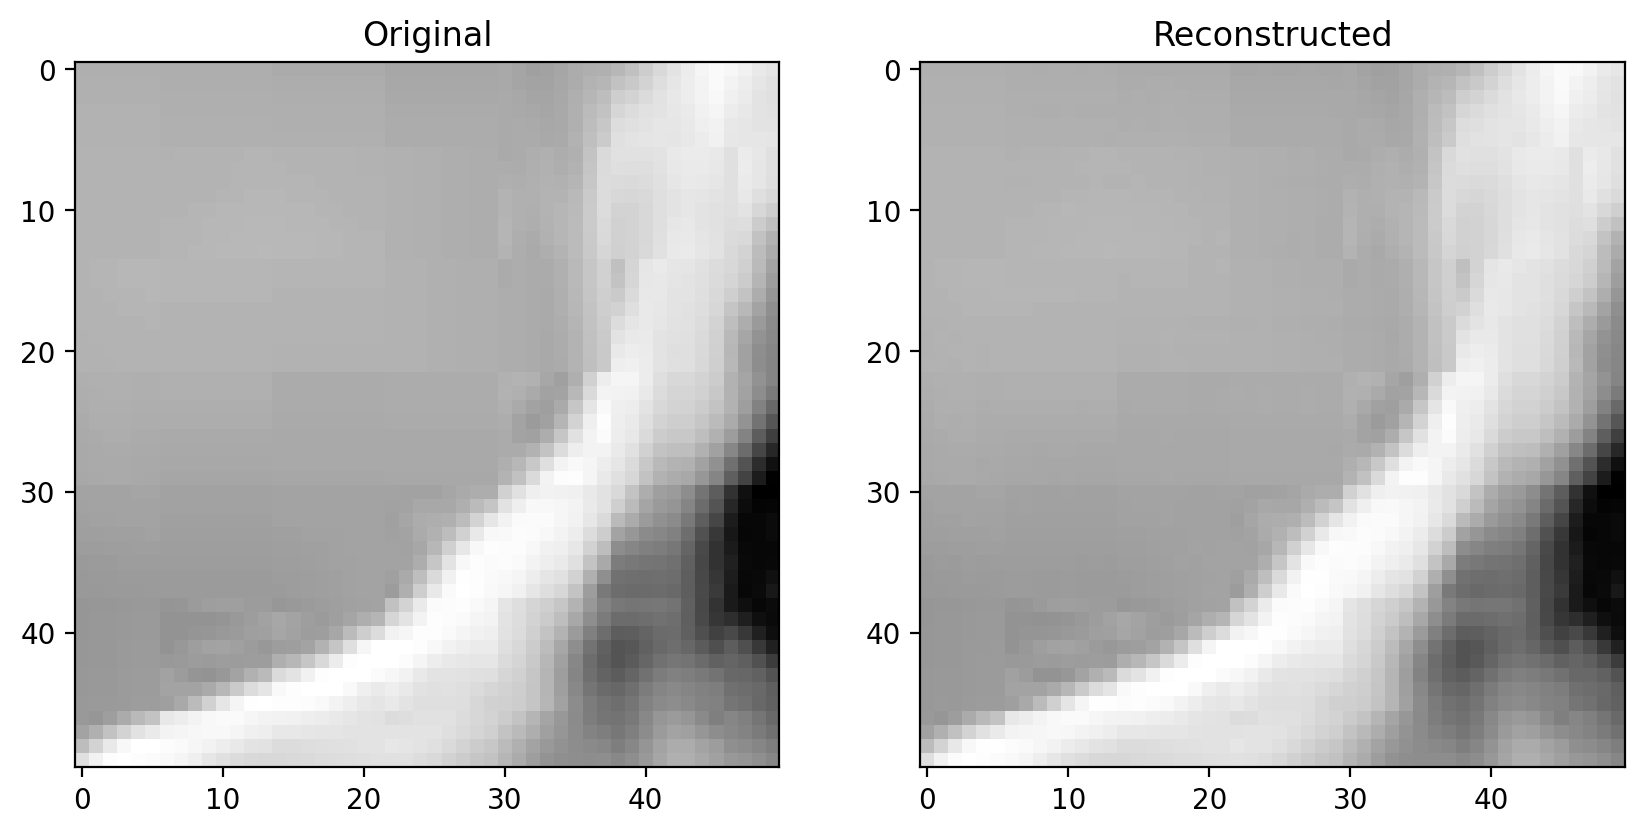

Patch 3


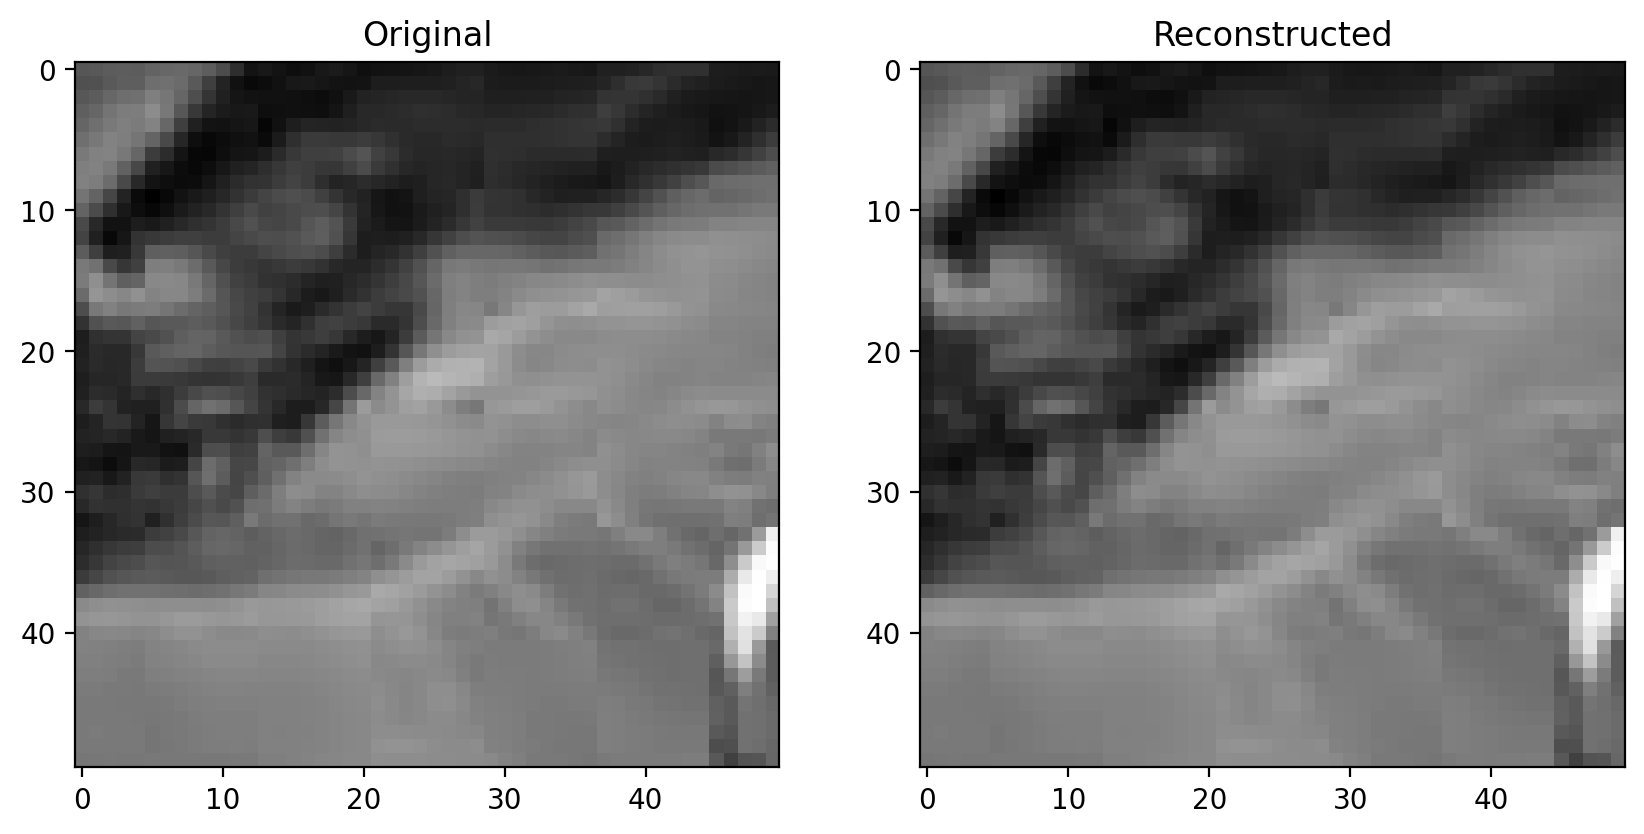

(0.2694853, 59.50874328613281)

In [23]:
print("Patch 1")
factorize_and_reconstruct_patch(1, 50, plot=True)
factorize_and_reconstruct_patch(1, 25, plot=True)
factorize_and_reconstruct_patch(1, 10, plot=True)
print("Patch 2")
factorize_and_reconstruct_patch(2, 50, plot=True)
print("Patch 3")
factorize_and_reconstruct_patch(3, 50, plot=True)

patch=1 r=5, RMSE=1.6362359523773193, PSNR=41.35889530181885
patch=1 r=10, RMSE=2.6306235790252686, PSNR=37.23463773727417
patch=1 r=25, RMSE=0.532549262046814, PSNR=51.10861778259277
patch=1 r=50, RMSE=0.532560408115387, PSNR=51.108436584472656


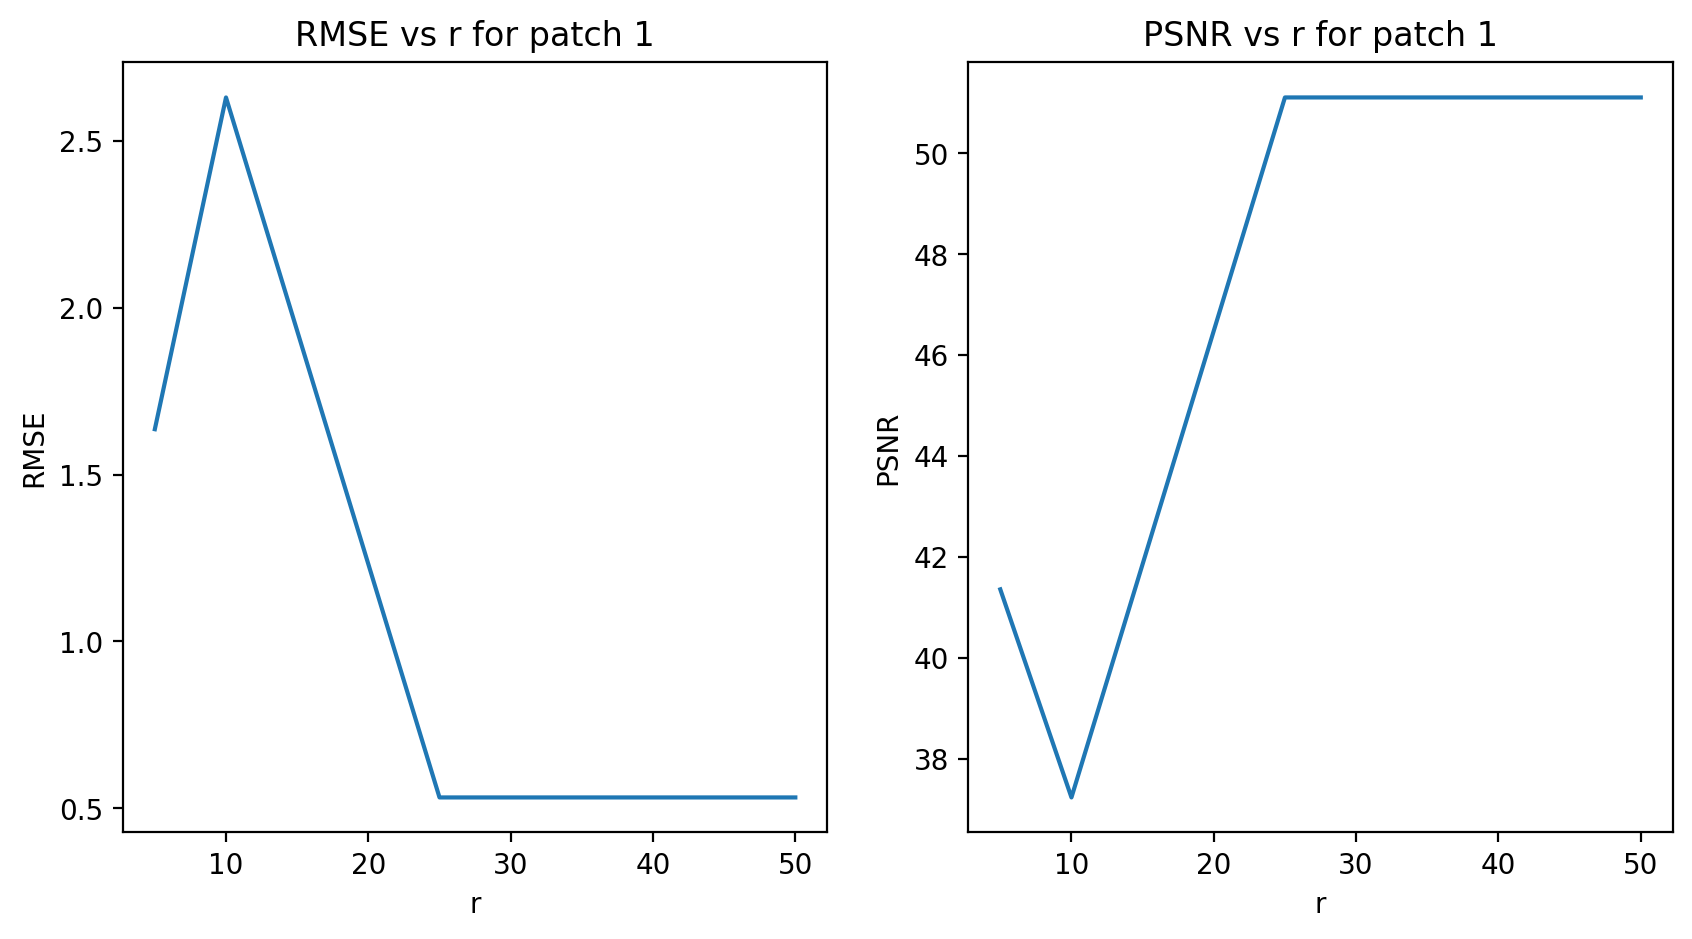

patch=2 r=5, RMSE=6.103981971740723, PSNR=32.41853952407837
patch=2 r=10, RMSE=2.2859034538269043, PSNR=40.949645042419434
patch=2 r=25, RMSE=0.9240461587905884, PSNR=48.81692886352539
patch=2 r=50, RMSE=3.3323452472686768, PSNR=37.67580270767212


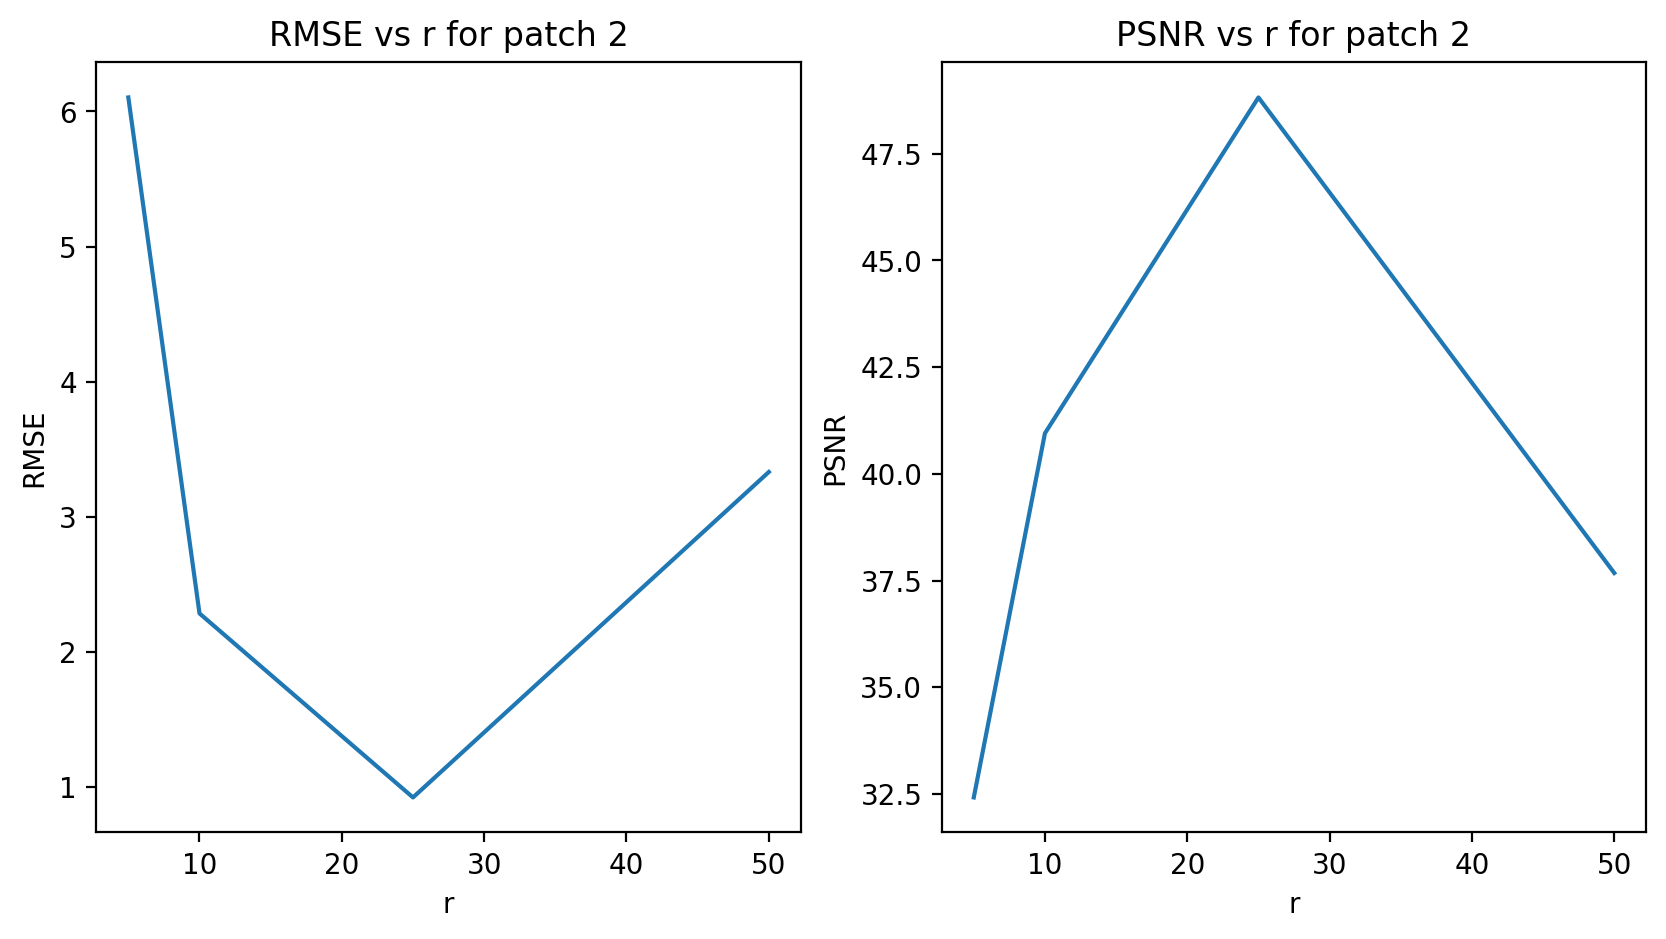

patch=3 r=5, RMSE=11.379051208496094, PSNR=26.997320652008057
patch=3 r=10, RMSE=4.358702659606934, PSNR=35.332298278808594
patch=3 r=25, RMSE=1.1663843393325806, PSNR=46.78260803222656
patch=3 r=50, RMSE=0.3285171687602997, PSNR=57.78828144073486


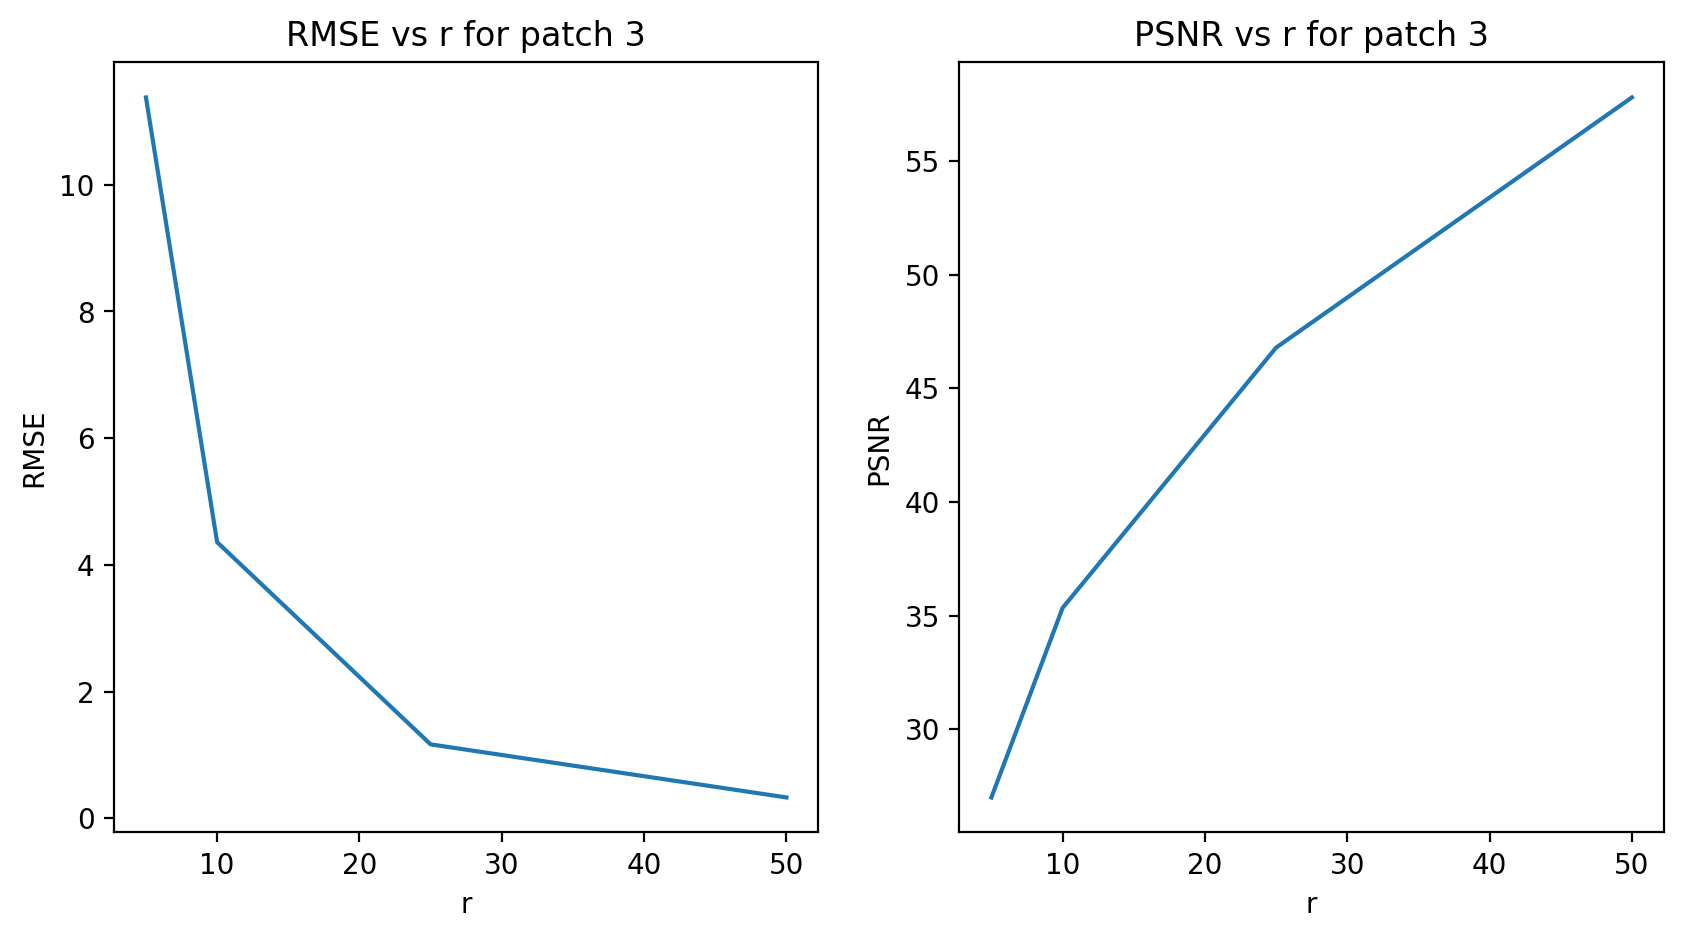

In [24]:
plot_metrics_vs_r(1, [5, 10, 25, 50])
plot_metrics_vs_r(2, [5, 10, 25, 50])
plot_metrics_vs_r(3, [5, 10, 25, 50])